In [9]:
thickness=20
square=True
image_path='/mnt/z9-slide-storage/VipsML/00-orig.tif'

[[(2633, 2633), (3159, 3422), (2633, 3422)], [(1579, 3159), (1448, 3159)]]


uchar


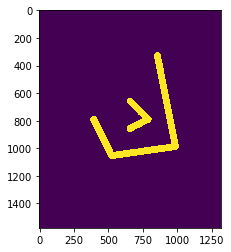

In [15]:
from math import atan2, pi, sin, cos, sqrt
from time import time
from random import random



class point():
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __add__(self,ob):
        return point(self.x+ob.x,self.y+ob.y)
    def __neg__(self):
        return point(-self.x,-self.y)
    def __sub__(self,ob):
        return ob+(-self)
    def __truediv__(self,n):
        return point(self.x/n,self.y/n)
    def __str__(self):
        return ("x: {}, y: {}".format(self.x,self.y))
    def hyp(self):
        return sqrt(self.x**2+self.y**2)

class planePoints():
    def __init__(self,xy):
        self.x=xy[0]
        self.y=xy[1]

class Segment():
    def __init__(self,c1,c2):
        self.p1 = point(c1[0],c1[1])
        self.p2 = point(c2[0],c2[1])
        self.dx = self.p2.x-self.p1.x
        self.dy = self.p2.y-self.p1.y
        self.offset = 25
        self.slope = self.dy/self.dx if self.dx != 0 else float('Inf')
        self.angle = atan2(self.dy,self.dx)
        self.maximas = (max(self.p1.x,self.p2.x),max(self.p1.y,self.p2.y))
        self.minimas = (min(self.p1.x,self.p2.x),min(self.p1.y,self.p2.y))
        self.bbox = (self.minimas[0]-self.offset,self.minimas[1]-self.offset,self.maximas[0]-self.minimas[0]+(2*self.offset),self.maximas[1]-self.minimas[1]+(2*self.offset))
    def testPoints(self,xy):
        p1=self.p1
        p2=self.p2
        p3=planePoints(xy.crop(*self.bbox))
        p4=planePoints([p3.x+self.dy,p3.y-self.dx])
        x=(((p1.x*p2.y-p1.y*p2.x)*(p3.x-p4.x)-(p1.x-p2.x)*(p3.x*p4.y-p3.y*p4.x)))/((p1.x-p2.x)*(p3.y-p4.y)-(p1.y-p2.y)*(p3.x-p4.x))
        y=(((p1.x*p2.y-p1.y*p2.x)*(p3.y-p4.y)-(p1.y-p2.y)*(p3.x*p4.y-p3.y*p4.x)))/((p1.x-p2.x)*(p3.y-p4.y)-(p1.y-p2.y)*(p3.x-p4.x))
        xmin=min(p1.x,p2.x)
        xmax=max(p1.x,p2.x)
        dx=p3.x-x
        dy=p3.y-y        
        result= (x<=xmax) & (x>=xmin) & (((dx**2+dy**2)**0.5)<self.offset)
        dx1 = p3.x-p1.x
        dy1 = p3.y-p1.y
        dx2 = p3.x-p2.x
        dy2 = p3.y-p2.y
        result |= (((dx1**2+dy1**2)**0.5)<self.offset) | (((dx2**2+dy2**2)**0.5)<self.offset)
        return result

import pyvips as vips

anns=[[(0.5,0.5),(0.6,0.6),(0.5,0.65)],[(0.3,0.6),(0.4,0.8),(0.75,0.75),(0.65,0.25)]]

im=vips.Image.new_from_file(image_path).resize(0.25)
pix_anns=[[(int(x*im.width),int(y*im.width)) for x,y in poly] for poly in anns]

xyz=vips.Image.xyz(im.width,im.height)

def testCopy(results):
    smart = random()>0.5
    t0=time()
    black=vips.Image.black(im.width,im.height)
    paint=vips.Image.black(im.width,im.height)
    for i in range(len(pix_anns)):
        for j in range(len(pix_anns[i])-1):
            segment=Segment(pix_anns[i][j],pix_anns[i][j+1])
            # "smart" copy
            if (smart):
                paint_segment=paint.crop(*segment.bbox)
                paint_segment|=segment.testPoints(xyz)
                paint=paint.insert(paint_segment,segment.bbox[0],segment.bbox[1])
            else:
                 paint|=black.insert(segment.testPoints(xyz),segment.bbox[0],segment.bbox[1])
    copy=(paint&im).copy_memory()
    results[smart]+=[time()-t0]
    show(paint)
result_array=[[],[]]
testCopy(result_array)
#for _ in range(25):
#    testCopy(result_array)
#print(sum(result_array[0])/len(result_array[0]),sum(result_array[1])/len(result_array[1]))

In [7]:
xyz=vips.Image.xyz(100,100)
pix_anns=[[(int(x*100),int(y*100)) for x,y in poly] for poly in anns]

In [11]:
from numpy import frombuffer, uint32, uint8,float32, squeeze
from matplotlib.pyplot import imshow, figure

def toNp8(im):
    return frombuffer(im.write_to_memory(), dtype=uint8).reshape(im.height, im.width, im.bands)
def toNp32(im):
    return frombuffer(im.write_to_memory(), dtype=uint32).reshape(im.height, im.width, im.bands)
def toNpFloat(im):
    return frombuffer(im.write_to_memory(), dtype=float32).reshape(im.height, im.width, im.bands)

def show(img):
    figure()
    print(img.format)
    conv=toNp8
    if img.format == 'float':
        conv=toNpFloat
    imshow(squeeze(conv(img),axis=2) if img.bands==1 else conv(img))#,origin='lower')



In [167]:
1/int('Inf')

ValueError: invalid literal for int() with base 10: 'Inf'